## Naftali N Indongo
## Essay Codes: RNN Models in Keras

In [1186]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [1187]:
np.random.seed()
import time
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.optimizers import adam
from keras.layers.recurrent import LSTM
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import SimpleRNN
from keras import optimizers
import keras.backend as K

import sklearn
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow as tf

## (1.) Loading data to python

In [1157]:
dataset = pd.read_csv('Dataset.csv', index_col=0 )
dataset.head()

,AMSTEOE,DAXINDX,FRCAC40,FTSE100,HNGKNGI,PDOWA,GALLS,COMP
0,261.36,1411.28,1482.89,2371.0,3225.97,23755.89,387.17,307.52
1,262.02,1419.76,1490.42,2382.0,3207.21,24102.98,391.44,308.37
2,263.32,1431.03,1490.42,2386.6,3216.11,24118.01,393.99,307.63
3,264.98,1440.47,1490.42,2403.0,3253.42,23931.52,390.23,310.68
4,264.50,1462.16,1490.42,2419.2,3262.30,23969.76,395.71,310.42


In [5]:
dataset.shape

(2734, 8)

### Plotting the stock indices

In this section we will plot our 8 different stock indices. Each stock index represents a stock trading on a certain stock market.

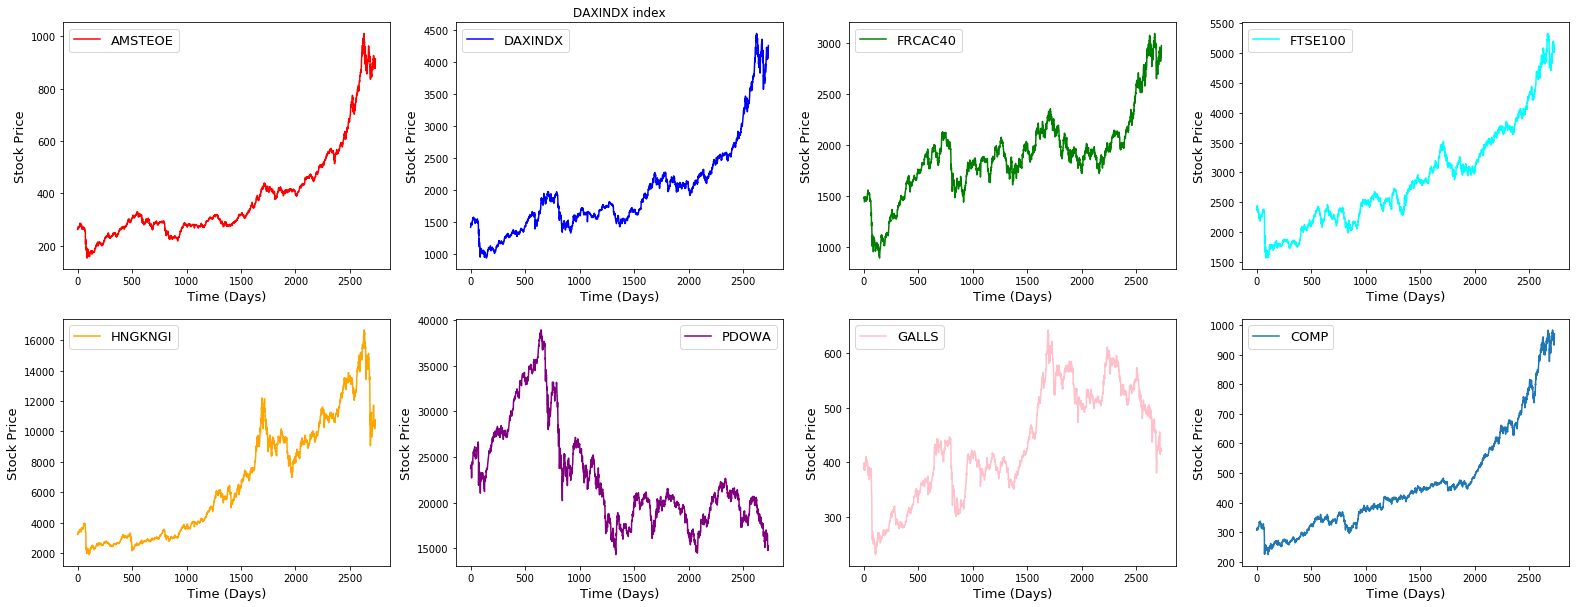

In [6]:
fig = plt.figure(figsize=(27,10))

#Plotting figure for AMSTEOE Index
fig.add_subplot(2,4,1)
plt.plot(dataset['AMSTEOE'].values, label = 'AMSTEOE', color = 'red')
#plt.title('AMSTEOE index')
plt.xlabel('Time (Days)', fontsize = 13)
plt.ylabel('Stock Price', fontsize = 13)
plt.legend(fontsize = 13)

#Plotting figure for DAXINDX Index
fig.add_subplot(2,4,2)
plt.plot(dataset['DAXINDX'], label = 'DAXINDX', color = 'blue')
plt.title('DAXINDX index')
plt.xlabel('Time (Days)', fontsize = 13)
plt.ylabel('Stock Price', fontsize = 13)
plt.legend(fontsize = 13)

#Plotting figure for FRCAC40 Index
fig.add_subplot(2,4,3)
plt.plot(dataset['FRCAC40'], label = 'FRCAC40', color = 'green')
#plt.title('FRCAC40 index')
plt.xlabel('Time (Days)', fontsize = 13)
plt.ylabel('Stock Price', fontsize = 13)
plt.legend(fontsize = 13)

#Plotting figure for FTSE100 Index
fig.add_subplot(2,4,4)
plt.plot(dataset['FTSE100'], label = 'FTSE100', color = 'cyan')
#plt.title('FTSE100 index')
plt.xlabel('Time (Days)', fontsize = 13)
plt.ylabel('Stock Price', fontsize = 13)
plt.legend(fontsize = 13)

#Plotting figure for HNGKNGI Index
fig.add_subplot(2,4,5)
plt.plot(dataset['HNGKNGI'], label = 'HNGKNGI', color = 'orange')
#plt.title('HNGKNGI index')
plt.xlabel('Time (Days)', fontsize = 13)
plt.ylabel('Stock Price', fontsize = 13)
plt.legend(fontsize = 13)

#Plotting figure for PDOWAIndex
fig.add_subplot(2,4,6)
plt.plot(dataset['PDOWA'], label = 'PDOWA', color = 'purple')
#plt.title('PDOWA index')
plt.xlabel('Time (Days)', fontsize = 13)
plt.ylabel('Stock Price', fontsize = 13)
plt.legend(fontsize = 13)

#Plotting figure for GALLS Index
fig.add_subplot(2,4,7)
plt.plot(dataset['GALLS'], label = 'GALLS', color = 'pink')
#plt.title('GALLS index')
plt.xlabel('Time (Days)', fontsize = 13)
plt.ylabel('Stock Price', fontsize = 13)
plt.legend(fontsize = 13)

#Plotting figure for COMP Index
fig.add_subplot(2,4,8)
plt.plot(dataset['COMP'], label = 'COMP')
#plt.title('COMP index')
plt.xlabel('Time (Days)', fontsize = 13)
plt.ylabel('Stock Price', fontsize = 13)
plt.legend(fontsize = 13)

plt.show()

### Dataset consisting of only predictors (Feutures)

We will use all the stock indices to predict AMSTEOE stock index.

In [7]:
stock_dataset = dataset
stock_dataset.head()
data1 = stock_dataset[['AMSTEOE']]
data1.head()

,AMSTEOE
0,261.36
1,262.02
2,263.32
3,264.98
4,264.50


In [8]:
print('the shape of the predicting dataset is ', stock_dataset.shape)

the shape of the predicting dataset is  (2734, 8)


## (2.) Data setup for Input to RNN's

### Normalizing the data

We will normalize our data to values between 0 and 1 using the python's MinMaxScaler function. 

In [9]:
def normaliser(data,frange =(0,1)):
    #normaliser feutures
    scaler = MinMaxScaler(feature_range=frange)
    dt = data.values
    #dt = dt.reshape(-1,1)
    scaled = scaler.fit_transform(dt)
    return scaled, scaler

In [10]:
#normalised_prices = normaliser(stock_dataset)

In [11]:
scaler1 = MinMaxScaler(feature_range = (0,1))
scaler2 = MinMaxScaler(feature_range = (0,1))
normalised_prices = scaler1.fit_transform(stock_dataset.values)
#prices_n = scaler2.fit_transform(stock_dataset[:].values)
normalised_prices[0:5] #Taking a look at our normalized values
n = scaler2.fit_transform(data1)

### Transforming the time series into well labelled training and testing dataset 

We will use the following function to transform time series into well labelled braining training and target samples. i.e we transform out input into a tuple (n_samples,n_timesteps,n_features)

In [12]:
def rnn_data_setup(data, lookback, delay, min_index, max_index):
    '''
    data:     Shape (n_samples,n_features). First column is the time series, other columns are the features.
    lookback: Number of time steps in the RNN >= 1
    delay:    The number of time steps to predict >= 1.
    min_index,max_index: The starting and ending indices of the time series portion to construct the data.
                         Allows constructing validation and test sets from the series in proper shape
    Returns: A tuple (x,y) of numpy arrays where x is in shape (n_samples,n_timesteps,n_features) and 
             y is in shape (n_samples,delay). y is an array of target arrays each of size delay. To forecast 
             a single value n timesteps ahead, set delay = n and take the last element of the forecast array.
    '''
    n_samples=(max_index+1)-min_index-(lookback-1)-delay
    samples = np.zeros((n_samples,lookback,data.shape[-1]))
    targets = np.zeros((n_samples,delay))
                  
    samp, targ = [], []
    for i in range(n_samples):  
        indices1 = range(i, i+lookback)
        indices2 = range(i + lookback, i + lookback + delay)
        samples[i] = data[indices1]
        targets[i,:] = data[indices2][0:delay][:,0] 
        #print(samples,targets)
    samp.append(samples);targ.append(targets)

    return np.array(samp)[0],np.array(targ)[0]

In [93]:
lookback = 5
delay = 1
min_index = 0
max_index = 2733
xdata, ydata = rnn_data_setup(normalised_prices, lookback, delay, min_index, max_index)
print('The shape of the input sample set is: ',  xdata.shape)
print('The shape of the target set is: ', ydata.shape)

The shape of the input sample set is:  (2729, 5, 8)
The shape of the target set is:  (2729, 1)


### Splitting the dataset into the training and testing sets

We are splitting the dataset of normalized stock prices into 80$\%$ and 20$\%$ for training and testing respectively. 20 $\%$ of training set will be assigned for validation at later stage.

In [1182]:
#Specifying the sizes of training and testing datasets.
train_size = int(len(xdata)*0.6)
valid_size = int(len(xdata)*0.2)
test_size = len(xdata) - train_size-valid_size

#Splitting the dataset into trainig, validation and testing.
xtrain, xvalid, xtest = xdata[0:train_size,:], xdata[train_size:train_size+valid_size,:], xdata[train_size+valid_size:len(xdata),:]
ytrain, yvalid, ytest = ydata[0:train_size,:], ydata[train_size:train_size+valid_size,:], ydata[train_size+valid_size:len(ydata),:]

print('The shape of the training sample is: ', xtrain.shape)
print('The shape of the validation sample is: ', xvalid.shape)
print('The shape of the testing sample is: ', xtest.shape)
print('The shape of the training target is: ', ytrain.shape)
print('The shape of the validation target is: ', yvalid.shape)
print('The shape of the testing target is: ', ytest.shape)

The shape of the training sample is:  (1637, 5, 8)
The shape of the validation sample is:  (545, 5, 8)
The shape of the testing sample is:  (547, 5, 8)
The shape of the training target is:  (1637, 1)
The shape of the validation target is:  (545, 1)
The shape of the testing target is:  (547, 1)


In [95]:
xtrain = np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1], -1))
xtest = np.reshape(xtest, (xtest.shape[0], xtest.shape[1], -1))

## Recurrent Neural Networks Models

## (A.) SimpleRNN model 

We will be are looking the best RNN model by looking the model's performance according to different variations in terms of its variables.  

#### Input variables

In [299]:
n_features = 8
lr = 0.00133#Learning rate
units = 16 #Number hidden units

In [1248]:
#define the model
model1 = Sequential()
model1.add(keras.layers.SimpleRNN(units, activation = 'linear', input_shape = (lookback, n_features), return_sequences =False))
model1.add(Dropout(0.0001))
model1.add(Dense(1))
opt = adam(lr)#, decay=1e-6)
model1.compile(optimizer = 'adam' , loss = 'mse', metrics=["mae"])
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_33 (SimpleRNN)    (None, 16)                400       
_________________________________________________________________
dropout_104 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_149 (Dense)            (None, 1)                 17        
Total params: 417
Trainable params: 417
Non-trainable params: 0
_________________________________________________________________


### (i.) Fitting the model

In [1249]:
np.random.seed(1)
result1=model1.fit(xtrain,ytrain, validation_data=(xvalid,yvalid), batch_size = 50, epochs=200, verbose=0)

In [1250]:
df = pd.DataFrame(result1.history)
df.tail()

,val_loss,val_mean_absolute_error,loss,mean_absolute_error
195,0.000082,0.007422,0.000069,0.005107
196,0.000118,0.009067,0.000069,0.005627
197,0.000081,0.007396,0.000063,0.004941
198,0.000414,0.018881,0.000061,0.005080
199,0.000135,0.009833,0.000064,0.005291


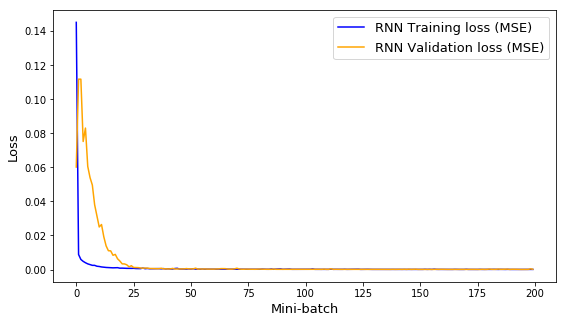

In [1251]:
print('')
plt.figure(figsize=(9,5))
plt.plot(df['loss'], label ='RNN Training loss (MSE)', color = 'blue')
plt.plot(df['val_loss'], label='RNN Validation loss (MSE)', color = 'orange')
plt.xlabel('Mini-batch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('RNN_error2.eps', format='eps', dpi=1000)
plt.show()

### (ii.) Predictions

Now we will use our model to make predictions.

In [304]:
preds1 = model1.predict(xtest)
preds1.shape


(547, 1)

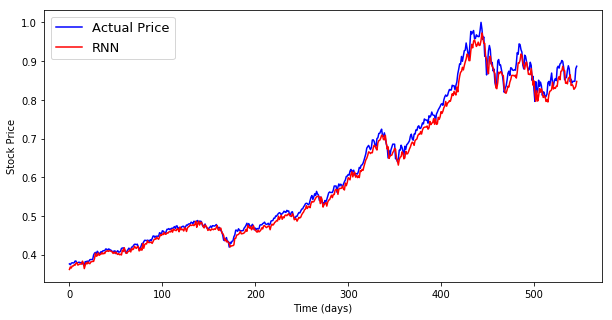

In [305]:
print('')
plt.figure(figsize=(10,5))
plt.plot(ytest, label="Actual Price", color = 'blue')
plt.plot(preds1, label="RNN", color = 'red')
plt.xlabel('Time (days)')
plt.ylabel('Stock Price')
plt.legend(fontsize=13)
plt.show()

In [1199]:
mean_absolute_error(ytest, preds1)

0.013280214071949141

In [306]:
#actuals = scaler2.inverse_transform(xtest)
real_pred1 = scaler2.inverse_transform(preds1)

In [1169]:
ytest=ytest.reshape(-1, 1)
actuals = scaler2.inverse_transform(ytest)
P = actuals[:,0]

547

In [1175]:
Prices2 = pd.DataFrame(P, columns = ['Prices'])
Prices2.to_csv('Actaul_Prices.csv', sep = ',', header = True)

#### Plot of Actual Stock Prices

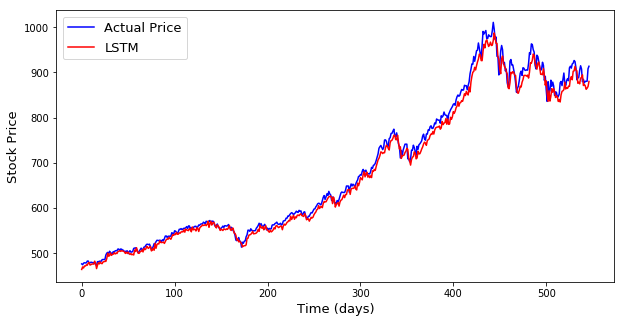

In [1211]:
print('')
plt.figure(figsize=(10,5))
plt.plot(actuals, label="Actual Price", color = 'blue')
plt.plot(real_pred1, label="LSTM", color = 'red')
plt.xlabel('Time (days)', fontsize=13)
plt.ylabel('Stock Price', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('LSTM_model2.png', format='png', dpi=1000)
plt.show()

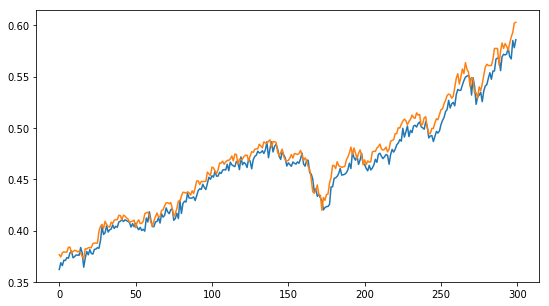

In [1181]:
plt.figure(figsize=(9,5))
plt.plot(preds1[:300,:])
plt.plot(ytest[:300,:])
plt.show()

### (iii.) RNN Model MSE

In [995]:
print('The the mean squared error committed by the standard RNN model is ', mean_squared_error(actuals,real_pred1))
print('The squaroot of the mean squared error committed by the standard RNN model is ', np.sqrt(mean_squared_error(actuals,real_pred1)))

The the mean squared error committed by the standard RNN model is  213.0064498810112
The squaroot of the mean squared error committed by the standard RNN model is  14.59474048693608


### (iv.) RNN Model MAPE

In [1231]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_pred)) * 100

In [1232]:
print('The the mean absolute percentage error committed by the standard RNN model is: ', mean_absolute_percentage_error(actuals,real_pred1))

The the mean absolute percentage error committed by the standard RNN model is:  1.600849119071349


### (v.) RNN Model MAE

In [1233]:
print('The the mean absolute error committed by the RNN model is: ', mean_absolute_error(actuals, real_pred1))

The the mean absolute error committed by the RNN model is:  11.40252644931159


## (B.) LSTM Model

In [1042]:
# Define the LSTM model
model2 = Sequential()
model2.add(LSTM(16, activation='linear', input_shape = (lookback,8), return_sequences = True))
model2.add(LSTM(16, return_sequences = True))
model2.add(Dropout(0.001))
model2.add(LSTM(16))
#model2.add(Dropout(0.001))
model2.add(Dense(1))
opt = adam(lr=0.00183)#, decay=1e-6)
model2.compile(loss='mse', optimizer=opt , metrics=["mae"])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_272 (LSTM)              (None, 5, 16)             1600      
_________________________________________________________________
lstm_273 (LSTM)              (None, 5, 16)             2112      
_________________________________________________________________
dropout_96 (Dropout)         (None, 5, 16)             0         
_________________________________________________________________
lstm_274 (LSTM)              (None, 16)                2112      
_________________________________________________________________
dense_141 (Dense)            (None, 1)                 17        
Total params: 5,841
Trainable params: 5,841
Non-trainable params: 0
_________________________________________________________________


### (i.) Fitting the model

In [1043]:
valid_score = 0.2
start = time.time()
np.random.seed(1)
result2=model2.fit(xtrain,ytrain,batch_size=300 ,nb_epoch=n_epochs,validation_split=valid_score, epochs=200, verbose = 0)
print("> Compilation Time : ", time.time() - start)

/Users/naftalindeapo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


> Compilation Time :  65.03265905380249


In [1044]:
df2 = pd.DataFrame(result2.history)
df2.tail()

,val_loss,val_mean_absolute_error,loss,mean_absolute_error
145,0.000034,0.004480,0.000035,0.004293
146,0.000024,0.003683,0.000036,0.004348
147,0.000029,0.004053,0.000034,0.004198
148,0.000035,0.004543,0.000035,0.004300
149,0.000026,0.003824,0.000035,0.004308


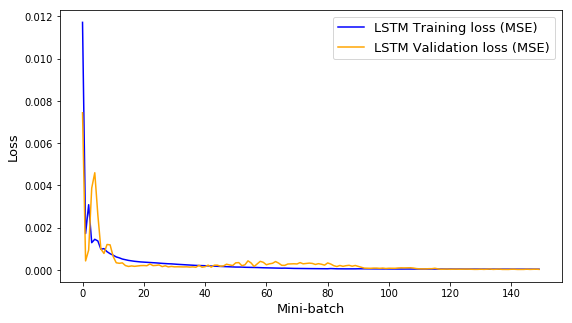

In [1225]:
plt.figure(figsize=(9,5))
plt.plot(df2['loss'], label ='LSTM Training loss (MSE)', color = 'blue')
plt.plot(df2['val_loss'], label='LSTM Validation loss (MSE)', color = 'orange')
plt.xlabel('Mini-batch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('LSTM2_error.eps', format='eps', dpi=1000)
plt.show()

### (ii.) Predictions

In [1047]:
# Doing a prediction on all the test data at once
preds2 = model2.predict(xtest)

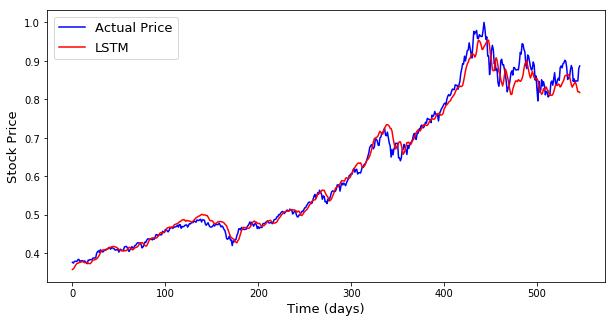

In [1139]:
plt.figure(figsize=(10,5))
plt.plot(ytest, label="Actual Price", color = 'blue')
plt.plot(preds2, label="LSTM", color = 'red')
plt.xlabel('Time (days)')
plt.ylabel('Stock Price')
plt.xlabel('Time (days)', fontsize=13)
plt.ylabel('Stock Price', fontsize=13)
plt.legend(fontsize=13)
plt.show()

In [1049]:
real_pred2 = scaler2.inverse_transform(preds2)

#### Plot of Actual Stock Prices

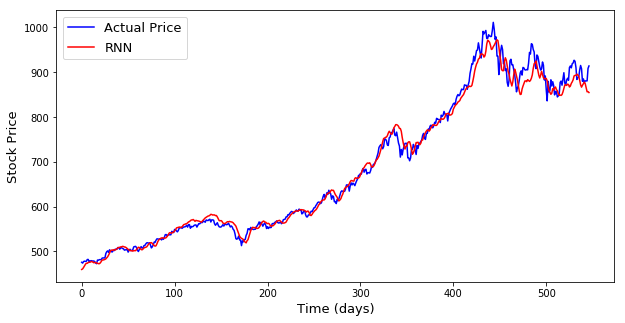

In [1210]:
plt.figure(figsize=(10,5))
plt.plot(actuals, label="Actual Price", color = 'blue')
plt.plot(real_pred2, label="RNN", color = 'red')
plt.xlabel('Time (days)', fontsize=13)
plt.ylabel('Stock Price', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('RNN_model2.png', format='png', dpi=1000)
plt.show()

### (iii) LSTM Model MSE

In [1141]:
print('The the mean squared error committed by the LSTM model is ', mean_squared_error(actuals,real_pred2))
print('The squareroot of the mean squared error committed by the LSTM model is ', np.sqrt(mean_squared_error(actuals,real_pred2)))

The the mean squared error committed by the LSTM model is  332.1925432341019
The squareroot of the mean squared error committed by the LSTM model is  18.22614998385841


### (iv.) LSTM Model MAPE

In [1142]:
print('The the mean absolute percentage error committed by the LSTM model is: ', mean_absolute_percentage_error(actuals,real_pred2))

The the mean absolute percentage error committed by the LSTM model is:  1.7021524750428434


### (iv.) LSTM Model MAE

In [1190]:
print('The the mean absolute error committed by the LSTM model is: ', mean_absolute_error(actuals, real_pred2))

The the mean absolute error committed by the LSTM model is:  12.55682936087823


## (C.) GRU Model

In [1124]:
# define model
model3 = Sequential()
model3.add(keras.layers.GRU(16, activation='linear', input_shape=(lookback, n_features)))
model3.add(Dropout(0.1811))
model3.add(Dense(1))
opt = keras.optimizers.Adam(lr=0.00143)
model3.compile(optimizer = opt, loss='mse', metrics=["mae"])
model3.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_16 (GRU)                 (None, 16)                1200      
_________________________________________________________________
dropout_103 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_148 (Dense)            (None, 1)                 17        
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
_________________________________________________________________


### (i.) Fitting the model

In [1125]:
n_epochs = 150
valid_score = 0.2
start = time.time()
result3 = model3.fit(xtrain,ytrain,batch_size=50,nb_epoch=n_epochs,validation_split=valid_score, verbose = 0)
model3.reset_states()
print("> Compilation Time : ", time.time() - start)

/Users/naftalindeapo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


> Compilation Time :  92.49720692634583


In [1126]:
df3 = pd.DataFrame(result3.history)
df3.tail()

,val_loss,val_mean_absolute_error,loss,mean_absolute_error
145,0.000017,0.003318,0.000064,0.005954
146,0.000016,0.003210,0.000066,0.005940
147,0.000009,0.002297,0.000063,0.005898
148,0.000010,0.002420,0.000072,0.006361
149,0.000014,0.002923,0.000070,0.005929


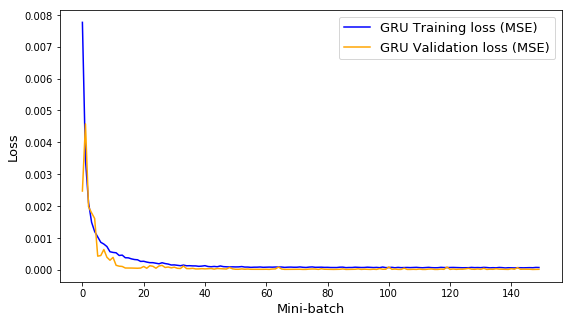

In [1227]:
print('')
plt.figure(figsize=(9,5))
plt.plot(df3['loss'], label ='GRU Training loss (MSE)', color = 'blue')
plt.plot(df3['val_loss'], label='GRU Validation loss (MSE)', color = 'orange')
plt.xlabel('Mini-batch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('GRU2_error.eps', format='eps', dpi=1000)
plt.show()

### (ii.) Predictions

In [1128]:
preds3 = model3.predict(xtest)

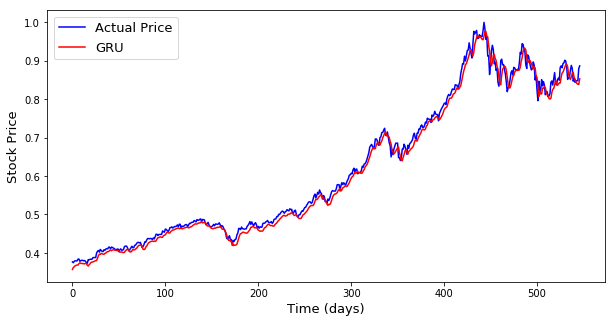

In [1143]:
plt.figure(figsize=(10,5))
plt.plot(ytest, label="Actual Price", color = 'blue')
plt.plot(preds3, label="GRU", color = 'red')
plt.xlabel('Time (days)', fontsize=13)
plt.ylabel('Stock Price', fontsize=13)
plt.legend(fontsize=13)
plt.show()

In [1144]:
real_pred3 = scaler2.inverse_transform(preds3)

#### Plot of Actual Stock Prices

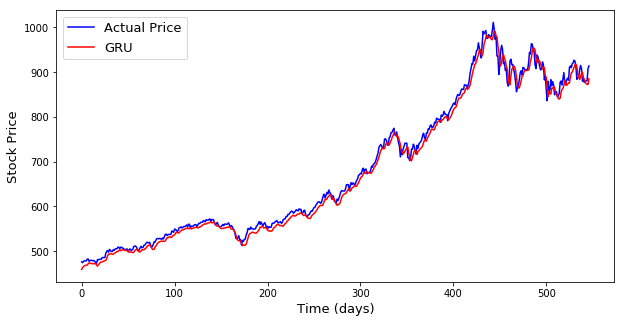

In [1226]:
print('')
plt.figure(figsize=(10,5))
plt.plot(actuals, label="Actual Price", color = 'blue')
plt.plot(real_pred3, label="GRU", color = 'red')
plt.xlabel('Time (days)', fontsize=13)
plt.ylabel('Stock Price', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('GRU_mide12.eps', format='eps', dpi=1000)
plt.show()

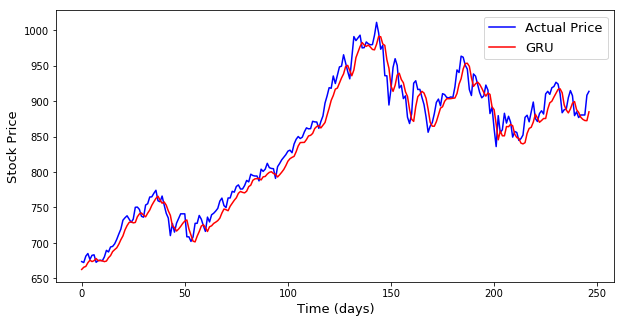

In [1146]:
plt.figure(figsize=(10,5))
plt.plot(actuals[300:], label="Actual Price", color = 'blue')
plt.plot(real_pred3[300:], label="GRU", color = 'red')
plt.xlabel('Time (days)', fontsize=13)
plt.ylabel('Stock Price', fontsize=13)
plt.legend(fontsize=13)
plt.show()

### (iii.) GRU Model MSE

In [1234]:
print('The the mean squared error committed by the GRU model is ', mean_squared_error(actuals,real_pred3))
print('The squareroot of the mean squared error committed by the GRU model is ', np.sqrt(mean_squared_error(actuals,real_pred3)))

The the mean squared error committed by the GRU model is  178.19460486906164
The squareroot of the mean squared error committed by the GRU model is  13.348955197657292


### (iv.) GRU Model MAPE

In [1134]:
print('The the mean absolute percentage error committed by the GRU model is: ', mean_absolute_percentage_error(actuals,real_pred3))

The the mean absolute percentage error committed by the GRU model is:  1.5794228040892686


### (v.) GRU Model MAE

In [1191]:
print('The the mean absolute error committed by the GRU model is: ', mean_absolute_error(actuals, real_pred3))

The the mean absolute error committed by the GRU model is:  10.793865502617264


## (D.) Combined Models

### Predicted Prices

In [1217]:
Pred_Data2=pd.DataFrame({'LSTM':real_pred1[:,0],'RNN':real_pred2[:,0],'GRU':real_pred3[:,0], 'Actual Price':actuals[:,0]})
Pred_Data2.head()

,LSTM,RNN,GRU,Actual Price
0,463.322449,459.683044,458.758209,475.62
1,468.946808,460.886261,463.139343,473.85
2,466.498901,464.065430,465.041748,477.22
3,471.037262,467.739075,467.108734,478.11
4,470.811768,471.078461,467.991455,477.77


In [1218]:
#saving dataset of predicted prices
Pred_Data2.to_csv('Pred_Data2.csv', sep = ',', header = True)

### Combined Plots

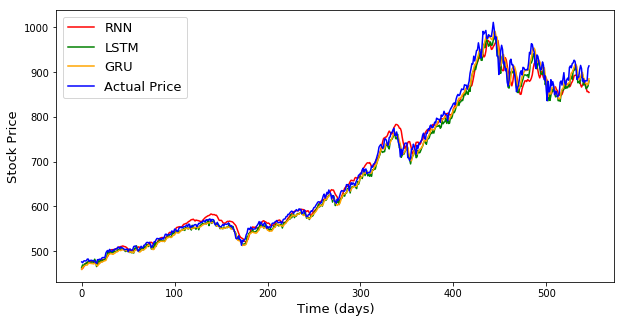

In [1208]:
plt.figure(figsize=(10,5))
plt.plot(Pred_Data2['RNN'], color = 'red')
plt.plot(Pred_Data2['LSTM'], color = 'green')
plt.plot(Pred_Data2['GRU'], color = 'orange')
plt.plot(actuals, color = 'blue', label = 'Actual Price')
plt.xlabel('Time (days)', fontsize=13)
plt.ylabel('Stock Price', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('Combined2.eps', format='eps', dpi=1000)
plt.show()

## (E.) Average of the three models

In [1236]:
predmean2=pd.DataFrame({'RNN':real_pred1[:,0],'LSTM':real_pred2[:,0],'GRU':real_pred3[:,0]}).mean(axis=1)
predmean2.head()

0    460.587891
1    464.324127
2    465.202026
3    468.628387
4    469.960571
dtype: float32

In [1237]:
predmean2.to_csv('Average2.csv', sep = ',', header = True)

### Plot of the  Average of the 3 Models against the actual prices

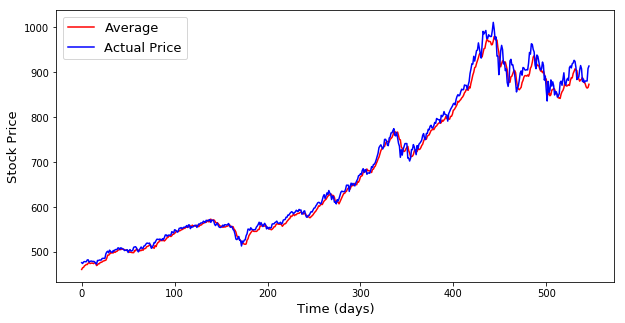

In [1238]:
plt.figure(figsize=(10,5))
plt.plot(predmean2, color = 'red', label = 'Average')
plt.plot(actuals, color = 'blue', label = 'Actual Price')
plt.xlabel('Time (days)', fontsize=13)
plt.ylabel('Stock Price', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('Average2.eps', format='eps', dpi=1000)
plt.show()

### Average Mean Squared Error (MSE)

In [1240]:
print('The the mean squared error committed by the LSTM model is ', mean_squared_error(actuals,predmean2))
print('The squareroot of the mean squared error committed by the LSTM model is ', np.sqrt(mean_squared_error(actuals,predmean2)))

The the mean squared error committed by the LSTM model is  190.10639167738907
The squareroot of the mean squared error committed by the LSTM model is  13.787907443748999


### Average Mean Absolute Percentage Error (MAPE)

In [1247]:
print('The the mean absolute percentage error committed by the average of the 3 models is: ', mean_absolute_percentage_error(actuals,predmean2)/20)

The the mean absolute percentage error committed by the average of the 3 models is:  1.339646154002606


### Average Mean Absolute Error

In [1194]:
print('The the mean absolute error committed by the LSTM model is: ', mean_absolute_error(actuals, predmean2))

The the mean absolute error committed by the LSTM model is:  10.076939837858495
